In [283]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from pandas import DataFrame
import pickle, random
from tqdm import tqdm
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

In [284]:
#!pip install matplotlib

In [285]:
#df0 = pd.read_csv('../spreadsheets/rlhf_20250104_6.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_159nlp.csv') # Best
#df0 = pd.read_csv('../spreadsheets/rlhf_1064_2.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_1072.csv') # 0.05, 0.95, 1.0, 0.999, 0.995, 12000
#df0 = pd.read_csv('../spreadsheets/shufled_rlhf_11rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_12rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_15rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_19rl.csv') # 0.005, 0.75, 0.1, 0.95, 0.999, 12000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_23rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_24rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_25rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_26rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_157nlp.csv') # 0.7, 0.95, 0.5, 0.999, 0.99, 16000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_29rl.csv') # 0.9, 0.9, 0.005, 0.95, 0.999, 10000, 0.9, 0.95, 1.0, 0.99, 0.99, 8000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_30rl.csv') # 
#df0 = pd.read_csv('../spreadsheets/rlhf_large_32rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_33rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_35rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_37rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_27rl2.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_38rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_42rl.csv') # 0.01, 0.99, 1.0, 0.95, 0.99, 16000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_154nlp.csv') # 0.9, 0.9, 0.005, 0.95, 0.999, 10000
#df0 = pd.read_csv('../spreadsheets/rlhf_bid_47rl_refined.csv')
df0 = pd.read_csv('../spreadsheets/rlhf_large_50rl.csv')

In [286]:
df0['ask'] = df0['close'] * df0['volume']/(df0['close'] + df0['open'])

In [287]:
df0['bid'] = df0['open'] * df0['volume']/(df0['close'] + df0['open'])

In [288]:
df0.columns

Index(['Unnamed: 0', 'open', 'high', 'ema-26', 'ema-12', 'low',
       'mean-grad-hist', 'close', 'volume', 'sma-25', 'long_jcrosk',
       'short_kdj', 'sma-05', 'sma-07', 'sma-compare', 'is_short', 'action',
       'imit-action', 'nlpreds', 'reward', 'ask', 'bid'],
      dtype='object')

In [289]:
df0.head()

,Unnamed: 0,open,high,ema-26,ema-12,low,mean-grad-hist,close,volume,sma-25,...,sma-05,sma-07,sma-compare,is_short,action,imit-action,nlpreds,reward,ask,bid
0,0,10.304000,10.332000,10.437047,10.597291,10.18100,0,10.326000,3.586200e+05,10.646800,...,10.363000,10.348714,0,1,go_short,go_short,go_short,-11.459495,1.795012e+05,1.791188e+05
1,1,445.750000,446.110000,444.906188,443.432365,443.10000,1,443.530000,1.751153e+03,442.440400,...,445.842000,446.728571,0,1,go_short,go_short,go_short,-10.390311,8.733907e+02,8.777623e+02
2,2,63.920000,63.970000,63.909498,64.056823,62.74000,1,62.760000,1.210974e+04,63.703600,...,64.152000,64.095714,0,1,go_short,go_short,go_short,-8.635224,5.999426e+03,6.110315e+03
3,3,0.028684,0.029109,0.028890,0.028528,0.02868,0,0.029104,7.112435e+08,0.028402,...,0.028976,0.028999,0,0,go_long,go_long,go_short,-6.819206,3.582064e+08,3.530371e+08
4,4,1.362600,1.362900,1.367365,1.377128,1.33500,1,1.340000,2.572130e+05,1.374716,...,1.357700,1.365729,1,1,go_short,go_short,go_long,-9.058079,1.275311e+05,1.296819e+05


In [290]:
#df0.drop(['Unnamed: 0'], axis=1, inplace=True)

In [291]:
df0['action'].value_counts()

action
go_short    21897
go_long      1003
Name: count, dtype: int64

In [292]:
#action_mapping = {"go_long": 0, "go_short": 1}

In [293]:
def prep_data(df: DataFrame) -> DataFrame:
    train_data = pd.DataFrame()
    for col in df.columns:
        col_name = col.split(' ')[0]
        train_data[f'{col_name}'] = df[col]

    return train_data

In [294]:
newdf0 = pd.DataFrame()
train_data = df0 if newdf0.empty else newdf0

In [295]:
train_data.head(2)

,Unnamed: 0,open,high,ema-26,ema-12,low,mean-grad-hist,close,volume,sma-25,...,sma-05,sma-07,sma-compare,is_short,action,imit-action,nlpreds,reward,ask,bid
0,0,10.304,10.332,10.437047,10.597291,10.181,0,10.326,358620.000,10.6468,...,10.363,10.348714,0,1,go_short,go_short,go_short,-11.459495,179501.217644,179118.782356
1,1,445.750,446.110,444.906188,443.432365,443.100,1,443.530,1751.153,442.4404,...,445.842,446.728571,0,1,go_short,go_short,go_short,-10.390311,873.390709,877.762291


In [296]:
new_cols = ['ask','bid','sma-compare','is_short']

In [297]:
# Encode actions into numerical values
action_mapping = {"go_long": 0, "go_short": 1, "do_nothing": 2}
action_col = 'nlpreds' if newdf0.empty else 'refined-action'
train_data["action_num"] = train_data[f"{action_col}"].map(action_mapping)

In [298]:
train_data.columns

Index(['Unnamed: 0', 'open', 'high', 'ema-26', 'ema-12', 'low',
       'mean-grad-hist', 'close', 'volume', 'sma-25', 'long_jcrosk',
       'short_kdj', 'sma-05', 'sma-07', 'sma-compare', 'is_short', 'action',
       'imit-action', 'nlpreds', 'reward', 'ask', 'bid', 'action_num'],
      dtype='object')

In [299]:
# Define RL parameters
#states = train_data[["sma-05", "sma-07", "sma-25", "sma-compare", "is_short"]].values  # Include binary_state
states = train_data[new_cols].values

actions = list(action_mapping.values())  # Action space
rewards = train_data["reward"].values  # Rewards
n_states = states.shape[0]
n_actions = len(actions)


In [300]:
# Initialize Q-table
q_table = np.zeros((n_states, n_actions))

In [301]:
Hyperparameters = [
    [0.1, 0.9, 0.1, 0.99, 0.995, 4000],
    [0.005, 0.75, 0.1, 0.95, 0.999, 12000],
    [0.001, 0.75, 1.0, 0.99, 0.99, 30000],
    [1, 0.75, 0.005, 0.95, 0.95, 22000],
    [0.01, 0.99, 1.0, 0.95, 0.99, 16000],
    [0.7, 0.99, 1.0, 0.95, 0.997, 8000],
    [0.01, 0.95, 1.0, 0.997, 0.995, 26000],
    [0.25, 0.95, 0.01, 0.997, 0.999, 14000],
    [0.5, 0.85, 0.5, 0.997, 0.997, 14000],
    [0.01, 0.85, 0.01, 0.95, 0.95, 12000],
    [0.9, 0.99, 0.5, 0.995, 0.95, 12000],
    [0.05, 0.9, 0.5, 0.95, 0.999, 4000],
    [0.05, 0.99, 0.5, 0.99, 0.997, 6000],
    [1, 0.75, 0.05, 0.999, 0.999, 10000],
    [0.9, 0.95, 1.0, 0.99, 0.99, 8000],
    [0.25, 0.75, 0.01, 0.995, 0.999, 20000],
    [0.3, 0.75, 1.0, 0.995, 0.99, 10000],
    [1, 0.9, 1.0, 0.999, 0.999, 10000],
    [0.7, 0.75, 1.0, 0.97, 0.999, 28000],
    [0.05, 0.95, 1.0, 0.999, 0.995, 12000],
    [0.7, 0.95, 0.5, 0.999, 0.99, 16000],
    [0.25, 0.95, 1.0, 0.99, 0.99, 10000],
    [0.25, 0.99, 0.01, 0.997, 0.99, 8000],
    [1, 0.95, 0.1, 0.96, 0.96, 12000],
    [0.9, 0.9, 0.005, 0.95, 0.999, 10000],
    [1, 0.9, 1.0, 0.99, 0.99, 11000],
    [0.5, 0.75, 0.005, 0.95, 0.999, 14000]

]

In [302]:
for i in enumerate(Hyperparameters):
    print(i)

(0, [0.1, 0.9, 0.1, 0.99, 0.995, 4000])
(1, [0.005, 0.75, 0.1, 0.95, 0.999, 12000])
(2, [0.001, 0.75, 1.0, 0.99, 0.99, 30000])
(3, [1, 0.75, 0.005, 0.95, 0.95, 22000])
(4, [0.01, 0.99, 1.0, 0.95, 0.99, 16000])
(5, [0.7, 0.99, 1.0, 0.95, 0.997, 8000])
(6, [0.01, 0.95, 1.0, 0.997, 0.995, 26000])
(7, [0.25, 0.95, 0.01, 0.997, 0.999, 14000])
(8, [0.5, 0.85, 0.5, 0.997, 0.997, 14000])
(9, [0.01, 0.85, 0.01, 0.95, 0.95, 12000])
(10, [0.9, 0.99, 0.5, 0.995, 0.95, 12000])
(11, [0.05, 0.9, 0.5, 0.95, 0.999, 4000])
(12, [0.05, 0.99, 0.5, 0.99, 0.997, 6000])
(13, [1, 0.75, 0.05, 0.999, 0.999, 10000])
(14, [0.9, 0.95, 1.0, 0.99, 0.99, 8000])
(15, [0.25, 0.75, 0.01, 0.995, 0.999, 20000])
(16, [0.3, 0.75, 1.0, 0.995, 0.99, 10000])
(17, [1, 0.9, 1.0, 0.999, 0.999, 10000])
(18, [0.7, 0.75, 1.0, 0.97, 0.999, 28000])
(19, [0.05, 0.95, 1.0, 0.999, 0.995, 12000])
(20, [0.7, 0.95, 0.5, 0.999, 0.99, 16000])
(21, [0.25, 0.95, 1.0, 0.99, 0.99, 10000])
(22, [0.25, 0.99, 0.01, 0.997, 0.99, 8000])
(23, [1, 0.95,

In [303]:
#print(*Hyperparameters[0])
'''
alpha = 1
gamma = 0.95
epsilon = 0.1
min_epsilon = 0.96
decay_rate = 0.96
n_episodes = 12000
'''

alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes = Hyperparameters[25] #Hyperparameters[26] #Hyperparameters[24] # Hyperparameters[9] # Hyperparameters[22] #Hyperparameters[6]



In [304]:
def create_state_index_mapping(df):
    state_to_index = {}
    for idx, row in df.iterrows():
        state = (row['ask'], row['bid'], row['sma-compare'], row['is_short'])
        state_to_index[state] = idx
    return state_to_index

# Assuming 'df' is your dataframe used during training
state_to_index = create_state_index_mapping(train_data)

# Save the state_to_index dictionary for later use
np.save('bids_state_to_index.npy', state_to_index)


In [305]:
# Helper function to choose an action using epsilon-greedy
def choose_action(state, epsilon):
    if np.random.uniform(0, 1) < epsilon:
        return np.random.randint(0, n_actions)  # Explore: random action
    else:
        return np.argmax(q_table[state])  # Exploit: best known action

evaluating results per episode ...:   0%|          | 4/11000 [00:00<07:28, 24.54it/s]

Episode 0/11000 - Total Reward: -16045.28484425999, Epsilon: 0.99


evaluating results per episode ...:   4%|▎         | 402/11000 [00:26<09:52, 17.89it/s]

Episode 400/11000 - Total Reward: -18395.921458699988, Epsilon: 0.99


evaluating results per episode ...:   7%|▋         | 801/11000 [00:54<11:27, 14.83it/s]

Episode 800/11000 - Total Reward: -14654.508306499967, Epsilon: 0.99


evaluating results per episode ...:  11%|█         | 1202/11000 [01:22<11:50, 13.79it/s]

Episode 1200/11000 - Total Reward: -13288.979864849964, Epsilon: 0.99


evaluating results per episode ...:  15%|█▍        | 1602/11000 [01:49<09:09, 17.11it/s]

Episode 1600/11000 - Total Reward: -17451.530251320004, Epsilon: 0.99


evaluating results per episode ...:  18%|█▊        | 2003/11000 [02:17<07:20, 20.42it/s]

Episode 2000/11000 - Total Reward: -19019.02489482, Epsilon: 0.99


evaluating results per episode ...:  22%|██▏       | 2402/11000 [02:46<11:42, 12.24it/s]

Episode 2400/11000 - Total Reward: -12191.409114939994, Epsilon: 0.99


evaluating results per episode ...:  25%|██▌       | 2803/11000 [03:15<09:02, 15.12it/s]

Episode 2800/11000 - Total Reward: -2029.6355102699372, Epsilon: 0.99


evaluating results per episode ...:  29%|██▉       | 3202/11000 [03:43<10:46, 12.07it/s]

Episode 3200/11000 - Total Reward: -12126.39547588, Epsilon: 0.99


evaluating results per episode ...:  33%|███▎      | 3602/11000 [04:13<07:33, 16.32it/s]

Episode 3600/11000 - Total Reward: -15571.876507109995, Epsilon: 0.99


evaluating results per episode ...:  36%|███▋      | 4003/11000 [04:42<07:39, 15.23it/s]

Episode 4000/11000 - Total Reward: -15899.594813679993, Epsilon: 0.99


evaluating results per episode ...:  40%|████      | 4402/11000 [05:11<08:14, 13.34it/s]

Episode 4400/11000 - Total Reward: -18722.542551069997, Epsilon: 0.99


evaluating results per episode ...:  44%|████▎     | 4802/11000 [05:37<06:35, 15.67it/s]

Episode 4800/11000 - Total Reward: -13820.445671009948, Epsilon: 0.99


evaluating results per episode ...:  47%|████▋     | 5202/11000 [06:04<07:54, 12.22it/s]

Episode 5200/11000 - Total Reward: -13430.042245079949, Epsilon: 0.99


evaluating results per episode ...:  51%|█████     | 5602/11000 [06:32<06:25, 14.01it/s]

Episode 5600/11000 - Total Reward: -2994.9227503899374, Epsilon: 0.99


evaluating results per episode ...:  55%|█████▍    | 6005/11000 [07:00<06:05, 13.67it/s]

Episode 6000/11000 - Total Reward: -18305.009874529987, Epsilon: 0.99


evaluating results per episode ...:  58%|█████▊    | 6404/11000 [07:26<05:10, 14.78it/s]

Episode 6400/11000 - Total Reward: -1053.7838184899865, Epsilon: 0.99


evaluating results per episode ...:  62%|██████▏   | 6804/11000 [07:54<07:59,  8.76it/s]

Episode 6800/11000 - Total Reward: -9123.932868010066, Epsilon: 0.99


evaluating results per episode ...:  65%|██████▌   | 7203/11000 [08:23<04:10, 15.17it/s]

Episode 7200/11000 - Total Reward: -2463.99600991997, Epsilon: 0.99


evaluating results per episode ...:  69%|██████▉   | 7604/11000 [08:51<02:53, 19.62it/s]

Episode 7600/11000 - Total Reward: -12282.443041899995, Epsilon: 0.99


evaluating results per episode ...:  73%|███████▎  | 8002/11000 [09:20<04:34, 10.92it/s]

Episode 8000/11000 - Total Reward: -766.4089097700102, Epsilon: 0.99


evaluating results per episode ...:  76%|███████▋  | 8407/11000 [09:49<02:48, 15.35it/s]

Episode 8400/11000 - Total Reward: -1944.3973785799271, Epsilon: 0.99


evaluating results per episode ...:  80%|████████  | 8804/11000 [10:16<02:06, 17.30it/s]

Episode 8800/11000 - Total Reward: -19031.67555602, Epsilon: 0.99


evaluating results per episode ...:  84%|████████▎ | 9202/11000 [10:43<02:10, 13.81it/s]

Episode 9200/11000 - Total Reward: -18441.43112846999, Epsilon: 0.99


evaluating results per episode ...:  87%|████████▋ | 9603/11000 [11:12<01:24, 16.58it/s]

Episode 9600/11000 - Total Reward: -12368.84414415001, Epsilon: 0.99


evaluating results per episode ...:  91%|█████████ | 10003/11000 [11:41<01:16, 12.99it/s]

Episode 10000/11000 - Total Reward: -17792.900248199996, Epsilon: 0.99


evaluating results per episode ...:  95%|█████████▍| 10404/11000 [12:09<00:36, 16.51it/s]

Episode 10400/11000 - Total Reward: -599.9407400600181, Epsilon: 0.99


evaluating results per episode ...:  98%|█████████▊| 10803/11000 [12:37<00:15, 12.94it/s]

Episode 10800/11000 - Total Reward: -12473.802626130011, Epsilon: 0.99


evaluating results per episode ...: 100%|██████████| 11000/11000 [12:52<00:00, 14.24it/s]


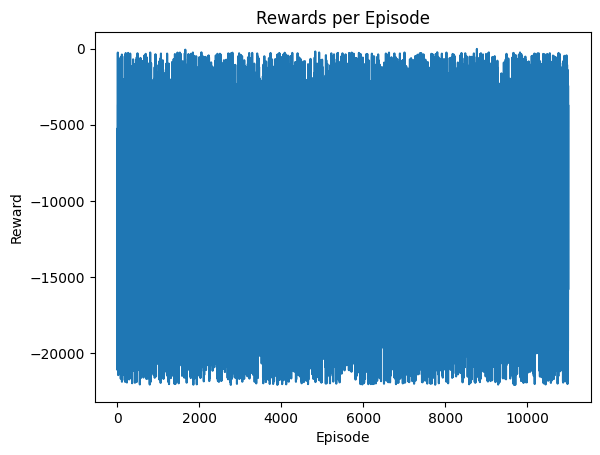

In [306]:

# Set random seed for reproducibility and train the loop
np.random.seed(42)
random.seed(42)
# Initialize a list to store rewards per episode
rewards_per_episode = []

for episode in tqdm(range(n_episodes), desc="evaluating results per episode ..."):
    current_state = np.random.randint(0, n_states)  # Random initial state
    total_reward = 0  # Initialize total reward for the current episode

    while current_state < n_states - 1:
        action = choose_action(current_state, epsilon)
        
        next_state = current_state + 1  # This depends on your environment logic
        reward = rewards[next_state]

        best_next_action = np.argmax(q_table[next_state])
        q_table[current_state, action] += alpha * (
            reward + gamma * q_table[next_state, best_next_action] - q_table[current_state, action]
        )
        
        total_reward += reward  # Accumulate reward for the current episode
        current_state = next_state  # Move to next state

    rewards_per_episode.append(total_reward)  # Store the total reward for the current episode

    # Decay epsilon
    epsilon = max(min_epsilon, epsilon * decay_rate)

    # Optional: Log progress
    if episode % 400 == 0:  # Adjust logging frequency as needed
        print(f"Episode {episode}/{n_episodes} - Total Reward: {total_reward}, Epsilon: {epsilon}")

# Example: Save the Q-table
np.save("bids_q_table.npy", q_table)

# Example: Plotting the rewards
import matplotlib.pyplot as plt

plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards per Episode')
plt.show()



In [307]:
def load_q_table(file_path):
    return np.load(file_path)

def load_state_index_mapping(file_path):
    return np.load(file_path, allow_pickle=True).item()

loaded_state_to_index = load_state_index_mapping(file_path="bids_state_to_index.npy")
loaded_qtable = load_q_table(file_path="bids_q_table.npy")

In [308]:
#state = (row['open'], row['high'], row['ema-26'], row['ema-12'], row['low'], \
#                 row['mean-grad-hist'], row['close'], row['volume'], row['sma-25'], \
#                 row['long_jcrosk'], row['short_kdj'], row['sma-compare'], row['is_short'])

def prep_state(
                ask: float, bid: float, sma_compare: int, is_short: int
            ):
    state = np.array([[ask, bid, sma_compare, is_short]])
    if not np.all(np.isfinite(state)):
        state = np.nan_to_num(state, nan=0.0, posinf=0.0, neginf=0.0)
    return state


In [309]:

def predict_action(state, q_table, state_to_index, action_mapping, default_action: str = None):
    state_tuple = tuple(state.flatten())

    state_index = state_to_index.get(state_tuple, -1)
    #state_index = loaded_state_to_index.get(state_tuple, -1)
    if state_index != -1:
        try:
            q_values = q_table[state_index]
        except ValueError as e:
            print(e)
            #return default_action
    else:
        state_tuples = list(state_to_index.keys())
        kdtree = KDTree(state_tuples)
        distance, index = kdtree.query(state.flatten())
        nearest_state_tuple = state_tuples[index]
        q_values = loaded_qtable[state_to_index[nearest_state_tuple]]
    
    #q_values = q_table[state_index]
    return [action for action, index in action_mapping.items() if index == np.argmax(q_values)][0]

In [310]:
# Predict an entire range
def predict_range(df: DataFrame = train_data) -> DataFrame:
    for idx, row in df.iterrows():
        state = row[['ask','bid','sma-compare', 'is_short']].values
        #q_table = loaded_qtable
        #state_to_index = loaded_state_to_index
        #action_mapping = {"go_long": 0, "go_short": 1, "do_nothing": 2}
        action = predict_action(state, q_table, state_to_index, action_mapping)
        df.loc[idx, "predicted_action"] = action
    return df

In [311]:
train_data = predict_range(train_data)

In [312]:
train_data['predicted_action'].value_counts()

predicted_action
go_long       22566
go_short        200
do_nothing      134
Name: count, dtype: int64

In [313]:
m = train_data[(train_data['predicted_action'] == 'go_long') & (train_data['reward'] > 0)]
m['is_short'].value_counts()

is_short
1    20493
0      939
Name: count, dtype: int64

In [314]:
longs = dict(m['is_short'].value_counts().items()).get(0)
print(longs)
shorts = dict(m['is_short'].value_counts().items()).get(1)
print(shorts)

939
20493


In [315]:
# Performance measures
# Initialize cumulative rewards
cumulative_predicted_reward = 0
cumulative_actual_reward = 0
#n_states = states.shape[0]
#q_table = loaded_qtable
# Iterate through states to calculate rewards
for state_index in range(n_states - 1):
    # Predicted action from Q-table
    predicted_action = np.argmax(q_table[state_index])  # Best action for the current state
    # Actual action from the ground truth
    actual_action = train_data["action_num"].iloc[state_index]

    # Get reward for predicted action only if it matches the actual action
    if predicted_action == actual_action:
        predicted_reward = rewards[state_index + 1]  # Reward for the correct prediction
        cumulative_predicted_reward += predicted_reward

    # Get actual reward for the ground truth action
    actual_reward = rewards[state_index + 1]
    cumulative_actual_reward += actual_reward

    # Optional: Log progress
    if state_index % 100 == 0:  # Adjust logging frequency as needed
        print(f"Processed state {state_index}/{n_states - 1}")
        print(f"Current Predicted Reward: {cumulative_predicted_reward}")
        print(f"Current Actual Reward: {cumulative_actual_reward}")

# Print results
print(f"Cumulative Predicted Reward: {cumulative_predicted_reward}")
print(f"Cumulative Actual Reward: {cumulative_actual_reward}")

# Optionally calculate efficiency
efficiency = (
    ((cumulative_predicted_reward - cumulative_actual_reward) / abs(cumulative_actual_reward)) * 100
    if cumulative_actual_reward != 0
    else 0
)
print(f"Prediction Efficiency: {efficiency:.2f}%")



Processed state 0/22899
Current Predicted Reward: 0
Current Actual Reward: -10.39031099
Processed state 100/22899
Current Predicted Reward: -5.940811860000018
Current Actual Reward: -81.90489316999994
Processed state 200/22899
Current Predicted Reward: 26.133953569999985
Current Actual Reward: -4.461696309999955
Processed state 300/22899
Current Predicted Reward: 78.09301181999997
Current Actual Reward: 110.30025739
Processed state 400/22899
Current Predicted Reward: 124.36028403
Current Actual Reward: 214.67899305000003
Processed state 500/22899
Current Predicted Reward: 161.24423028000007
Current Actual Reward: 363.77701687999996
Processed state 600/22899
Current Predicted Reward: 183.1689004600001
Current Actual Reward: 471.99834889999977
Processed state 700/22899
Current Predicted Reward: 183.1689004600001
Current Actual Reward: 570.2997075199997
Processed state 800/22899
Current Predicted Reward: 183.1689004600001
Current Actual Reward: 637.4957714699999
Processed state 900/22899


In [316]:
# Accuracy
correct_predictions = 0
for state_index in range(n_states):
    predicted_action = np.argmax(q_table[state_index])  # Predicted action
    actual_action = train_data["action_num"].iloc[state_index]  # Actual action
    if predicted_action == actual_action:
        correct_predictions += 1

accuracy = correct_predictions / n_states
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 5.49%


In [317]:
# Confusion matrix
y_true = train_data["action_num"]  # Actual actions
y_pred = [np.argmax(q_table[state_index]) for state_index in range(n_states)]  # Predicted actions

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 1059     1     1]
 [21507   199   133]
 [    0     0     0]]


In [318]:
def confusion_accuracy(conf_matrix, n_states):
    # True Positives (TP): Diagonal elements of the confusion matrix
    TP = conf_matrix[0][0] + conf_matrix[1][1] + conf_matrix[2][2]
    # **True Positives**: 16 (class 0), 0 (class 1), 0 (class 2)
    return TP*100/n_states

In [319]:
#con_acc = confusion_accuracy(cm, n_states=n_states)
#print(f"confusion accuracy: {con_acc:.2f}%")

In [320]:
df0['is_short'].value_counts()

is_short
1    21897
0     1003
Name: count, dtype: int64

In [321]:
def action_reward(action: str, is_short: int):
    m = train_data[(train_data['predicted_action'] == f'{action}') & (train_data['is_short'] == is_short)]
    counts = m['is_short'].value_counts()
    total_reward = m['reward'].cumsum()[-1:].values[0]
    wins = len(m[m['reward'] > 0])
    losses = len(m[m['reward'] <= 0])
    return {
        'counts': counts.get(is_short),
        'total reward': total_reward,
        'winrate': f'{wins * 100 / (losses + wins):.2f}%',
        'per trade profit': m[m['reward'] > 0]['reward'].sum() / wins,
        'per trade loss': m[m['reward'] <= 0]['reward'].sum() / losses
    }

In [322]:
action_reward('go_long', 0)

{'counts': 1002,
 'total reward': -44.0996075499998,
 'winrate': '93.71%',
 'per trade profit': 1.137017633312034,
 'per trade loss': -17.646970876666664}

In [323]:

dirs = [0,1]
for action in action_mapping.keys():
    for is_short in dirs:
        try:
            print(f'{action} {is_short}: {action_reward(action, is_short)}')
        except IndexError as e:
            print(e)
            


go_long 0: {'counts': 1002, 'total reward': -44.0996075499998, 'winrate': '93.71%', 'per trade profit': 1.137017633312034, 'per trade loss': -17.646970876666664}
go_long 1: {'counts': 21564, 'total reward': -628.0213629899955, 'winrate': '95.03%', 'per trade profit': 0.9995474176172352, 'per trade loss': -19.712181692082165}
go_short 0: {'counts': 1, 'total reward': -3.60169813, 'winrate': '0.00%', 'per trade profit': nan, 'per trade loss': -3.60169813}
go_short 1: {'counts': 199, 'total reward': 114.64950858000007, 'winrate': '95.98%', 'per trade profit': 1.0214986905235603, 'per trade loss': -10.057092663750002}
index 0 is out of bounds for axis 0 with size 0
do_nothing 1: {'counts': 134, 'total reward': 141.91113903000007, 'winrate': '97.76%', 'per trade profit': 1.2791417797709923, 'per trade loss': -8.552144706666667}


/tmp/ipykernel_3167762/3005952004.py:11: RuntimeWarning: invalid value encountered in scalar divide
  'per trade profit': m[m['reward'] > 0]['reward'].sum() / wins,


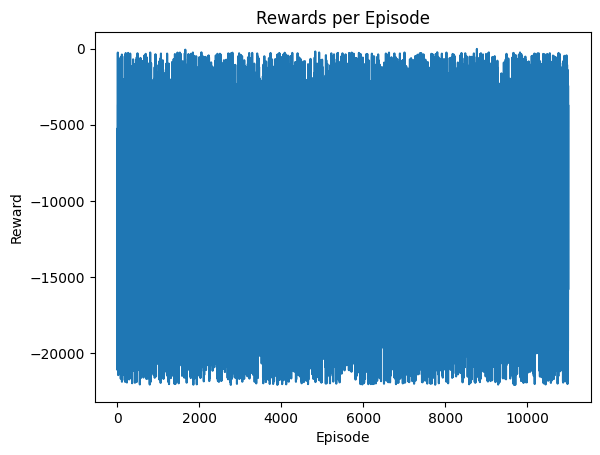

In [324]:
import matplotlib.pyplot as plt

# Assuming you have a list of rewards for each episode
#rewards_per_episode = [...]  # Populate this with your actual data

plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards per Episode')
plt.show()


In [325]:
# create corrected action
def correct_action(row):
    if row['predicted_action'] == 'go_long' and row['is_short'] == 1 and row['reward'] > 0:
        return 'go_short'
    if row['predicted_action'] == 'go_short' and row['is_short'] == 0 and row['reward'] > 0:
        return 'go_long'
    if row['predicted_action'] == 'do_nothing' and row['is_short'] == 1 and row['reward'] > 0:
        return 'go_short'
    if row['predicted_action'] == 'do_nothing' and row['is_short'] == 0 and row['reward'] > 0:
        return 'go_long'
    return row['predicted_action']

def refiner_action(version: str, data: DataFrame = None) -> DataFrame:
    data['refined-action'] = data.apply(lambda x: correct_action(x), axis=1)
    # Validation: Ensure we're fixing the 751 misclassified entries
    misclassified = data[
        (data['predicted_action'] == 'go_long') & 
        (data['refined-action'] == 'go_short')
    ]
    # Add this after applying refined-action
    confusion_matrix = pd.crosstab(
        data['refined-action'], 
        data['predicted_action'],  # Assuming you have ground truth column
        rownames=['refined'],
        colnames=['predicted']
    )
    print("Updated Confusion Matrix:")
    print(confusion_matrix) 
    print(f"Corrected {len(misclassified)} go_long->go_short misclassifications")
    filename = f'../spreadsheets/rlhf_bid_{version}_refined.csv'
    data.to_csv(filename, index=False)
    return data

In [326]:
base_dir = '/home/defi/Desktop/portfolio/projects/python/pipeline_defi/'
#new_data = pd.read_csv('../spreadsheets/rlhf_small_154nlp.csv') 
def refine_file(version: str, file) -> DataFrame:
    filename = f'{base_dir}{file}.csv'
    print(filename)
    df = pd.read_csv(filename)
    #new_data = prep_data(df0.copy()) if newdf0.empty else prep_data(newdf0.copy())
    new_data = prep_data(df)   
    print(new_data.columns)
    new_train_data = refiner_action(version=version, data=new_data)

    #new_data = df0.copy()
    print(new_train_data.columns)

    new_train_data['nlpreds'] = new_train_data['predicted_action']
    #new_train_data['predicted_action'] = new_train_data['predicted_action']
    return new_train_data

In [327]:
newdf0 = refine_file('154nlp', 'lean_df_154nlp')

/home/defi/Desktop/portfolio/projects/python/pipeline_defi/lean_df_154nlp.csv
Index(['open', 'high', 'ema-26', 'ema-12', 'low', 'mean-grad-hist', 'close',
       'volume', 'sma-25', 'long_jcrosk', 'short_kdj', 'sma-compare', 'ask',
       'bid', 'is_short', 'predicted_action', 'reward'],
      dtype='object')
Updated Confusion Matrix:
predicted   do_nothing  go_long  go_short
refined                                  
do_nothing          12        0         0
go_long              1      356         0
go_short             1      197         4
Corrected 197 go_long->go_short misclassifications
Index(['open', 'high', 'ema-26', 'ema-12', 'low', 'mean-grad-hist', 'close',
       'volume', 'sma-25', 'long_jcrosk', 'short_kdj', 'sma-compare', 'ask',
       'bid', 'is_short', 'predicted_action', 'reward', 'refined-action'],
      dtype='object')


In [328]:
# Tuning
'''
def train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards):
    q_table = np.zeros((n_states, n_actions))
    rewards_per_episode = []

    for episode in range(n_episodes):
        current_state = np.random.randint(0, n_states)
        total_reward = 0

        while current_state < n_states - 1:
            if np.random.uniform(0, 1) < epsilon:
                action = np.random.randint(0, n_actions)
            else:
                action = np.argmax(q_table[current_state])

            next_state = current_state + 1  # Adjust based on environment logic
            reward = rewards[next_state]

            best_next_action = np.argmax(q_table[next_state])
            q_table[current_state, action] += alpha * (
                reward + gamma * q_table[next_state, best_next_action] - q_table[current_state, action]
            )

            total_reward += reward
            current_state = next_state

        rewards_per_episode.append(total_reward)
        epsilon = max(min_epsilon, epsilon * decay_rate) # default min_epsilon = 0.01

    return q_table, rewards_per_episode
'''

'\ndef train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards):\n    q_table = np.zeros((n_states, n_actions))\n    rewards_per_episode = []\n\n    for episode in range(n_episodes):\n        current_state = np.random.randint(0, n_states)\n        total_reward = 0\n\n        while current_state < n_states - 1:\n            if np.random.uniform(0, 1) < epsilon:\n                action = np.random.randint(0, n_actions)\n            else:\n                action = np.argmax(q_table[current_state])\n\n            next_state = current_state + 1  # Adjust based on environment logic\n            reward = rewards[next_state]\n\n            best_next_action = np.argmax(q_table[next_state])\n            q_table[current_state, action] += alpha * (\n                reward + gamma * q_table[next_state, best_next_action] - q_table[current_state, action]\n            )\n\n            total_reward += reward\n            current_state = next_state\n\n  

In [329]:

def evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards):
    correct_predictions = 0
    total_reward = 0
    reward_weighted_accuracy = []

    # Add tqdm for progress visualization
    for state_index in tqdm(range(n_states), desc="Evaluating States"):
        predicted_action = np.argmax(q_table[state_index])  # Predicted action
        actual_action = train_data["action_num"].iloc[state_index]  # Actual action
        reward = rewards[state_index]  # Reward for the action

        if predicted_action == actual_action:
            correct_predictions += 1
            total_reward += reward

        accuracy = correct_predictions / (state_index + 1)
        reward_weighted_accuracy.append(total_reward / (state_index + 1))

        # Optional: Log progress
        if state_index % 100 == 0:
            print(f"Processed state {state_index}/{n_states} - Accuracy: {accuracy * 100:.2f}%, Reward-weighted Accuracy: {reward_weighted_accuracy[-1]}")

    final_reward_weighted_accuracy = total_reward / n_states
    return final_reward_weighted_accuracy * 100



In [330]:
'''
def random_search_reward_weighted(n_iter, param_grid, n_states, n_actions, rewards, train_data):
    best_params = None
    best_reward_weighted_accuracy = float('-inf')

    for _ in tqdm(range(n_iter), desc="Searching for params ..."):
        alpha = random.choice(param_grid['alpha'])
        gamma = random.choice(param_grid['gamma'])
        epsilon = random.choice(param_grid['epsilon'])
        min_epsilon = random.choice(param_grid['decay_rate'])
        decay_rate = random.choice(param_grid['decay_rate'])
        n_episodes = random.choice(param_grid['n_episodes'])

        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)
        reward_weighted_accuracy = evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards)

        if reward_weighted_accuracy > best_reward_weighted_accuracy:
            best_reward_weighted_accuracy = reward_weighted_accuracy
            best_params = (alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes)

        print(f"Iteration Reward-weighted Accuracy: {reward_weighted_accuracy:.2f}%, Best Reward-weighted Accuracy: {best_reward_weighted_accuracy:.2f}%")

    return best_params, best_reward_weighted_accuracy

# Define the parameter grid
param_grid = {
    'alpha': [0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.5, 0.7, 0.9, 1],
    'gamma': [0.75, 0.85, 0.9, 0.95, 0.99],
    'epsilon': [1.0, 0.5, 0.1, 0.05, 0.01, 0.005],
    'min_epsilon': [0.05, 0.01, 0.005, 0.001, 0.001],
    'decay_rate': [0.95, 0.99, 0.995, 0.997, 0.999],
    'n_episodes': [1500, 4000,6000, 8000, 9000, 10000, 11000, 12000]
}

# Perform Random Search
best_params, best_reward_weighted_accuracy = random_search_reward_weighted(50, param_grid, n_states, n_actions, rewards, train_data)
print(f"Best Hyperparameters: {best_params}")
print(f"Best Reward-weighted Accuracy: {best_reward_weighted_accuracy:.2f}%")

'''

'\ndef random_search_reward_weighted(n_iter, param_grid, n_states, n_actions, rewards, train_data):\n    best_params = None\n    best_reward_weighted_accuracy = float(\'-inf\')\n\n    for _ in tqdm(range(n_iter), desc="Searching for params ..."):\n        alpha = random.choice(param_grid[\'alpha\'])\n        gamma = random.choice(param_grid[\'gamma\'])\n        epsilon = random.choice(param_grid[\'epsilon\'])\n        min_epsilon = random.choice(param_grid[\'decay_rate\'])\n        decay_rate = random.choice(param_grid[\'decay_rate\'])\n        n_episodes = random.choice(param_grid[\'n_episodes\'])\n\n        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)\n        reward_weighted_accuracy = evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards)\n\n        if reward_weighted_accuracy > best_reward_weighted_accuracy:\n            best_reward_weighted_accuracy = reward_weighted_accuracy\n        

In [331]:
def evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards):
    # Initialize cumulative rewards
    cumulative_predicted_reward = 0
    cumulative_actual_reward = 0

    # Iterate through states to calculate rewards
    for state_index in range(n_states - 1):
        # Predicted action from Q-table
        predicted_action = np.argmax(q_table[state_index])  # Best action for the current state
        # Actual action from the ground truth
        actual_action = train_data["action_num"].iloc[state_index]

        # Get reward for predicted action only if it matches the actual action
        if predicted_action == actual_action:
            predicted_reward = rewards[state_index + 1]  # Reward for the correct prediction
            cumulative_predicted_reward += predicted_reward

        # Get actual reward for the ground truth action
        actual_reward = rewards[state_index + 1]
        cumulative_actual_reward += actual_reward
    return cumulative_predicted_reward

In [332]:
'''
train_data = newdf0
def random_search_prediction_efficiency(n_iter, param_grid, n_states, n_actions, rewards, train_data):
    best_params = None
    best_cumulative_pred_reward = float('-inf')

    for _ in tqdm(range(n_iter), desc="Searching for params ..."):
        alpha = random.choice(param_grid['alpha'])
        gamma = random.choice(param_grid['gamma'])
        epsilon = random.choice(param_grid['epsilon'])
        min_epsilon = random.choice(param_grid['decay_rate'])
        decay_rate = random.choice(param_grid['decay_rate'])
        n_episodes = random.choice(param_grid['n_episodes'])

        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)
        cumulative_pred_reward = evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards)

        if cumulative_pred_reward > best_cumulative_pred_reward:
            best_cumulative_pred_reward = cumulative_pred_reward
            best_params = (alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes)

        print(f"Iteration cumulative predicted reward: {cumulative_pred_reward:.2f}%, Best cumulative predicted reward: {best_cumulative_pred_reward:.2f}%")

    return best_params, best_cumulative_pred_reward

# Define the parameter grid
param_grid = {
    'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.5, 0.7, 0.9, 1],
    'gamma': [0.75, 0.85, 0.9, 0.95, 0.99],
    'epsilon': [1.0, 0.5, 0.1, 0.05, 0.01, 0.005],
    'min_epsilon': [0.05, 0.01, 0.005, 0.001, 0.001],
    'decay_rate': [0.95, 0.99, 0.995, 0.997, 0.999],
    'n_episodes': [1500, 4000,6000, 8000, 9000, 10000, 11000, 12000, 14000, 16000, 18000, 20000, 22000, 24000, 26000, 28000, 30000]
}
# 1500, 4000,6000, 8000, 9000, 10000, 11000, 
# Perform Random Search
best_params, best_cumulative_pred_reward = random_search_prediction_efficiency(50, param_grid, n_states, n_actions, rewards, train_data)
print(f"Best Hyperparameters: {best_params}")
print(f"Best cumulative predicted reward: {best_cumulative_pred_reward:.2f}%")
'''

'\ntrain_data = newdf0\ndef random_search_prediction_efficiency(n_iter, param_grid, n_states, n_actions, rewards, train_data):\n    best_params = None\n    best_cumulative_pred_reward = float(\'-inf\')\n\n    for _ in tqdm(range(n_iter), desc="Searching for params ..."):\n        alpha = random.choice(param_grid[\'alpha\'])\n        gamma = random.choice(param_grid[\'gamma\'])\n        epsilon = random.choice(param_grid[\'epsilon\'])\n        min_epsilon = random.choice(param_grid[\'decay_rate\'])\n        decay_rate = random.choice(param_grid[\'decay_rate\'])\n        n_episodes = random.choice(param_grid[\'n_episodes\'])\n\n        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)\n        cumulative_pred_reward = evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards)\n\n        if cumulative_pred_reward > best_cumulative_pred_reward:\n            best_cumulative_pred_reward = cumulative_

In [333]:
colsa = ['ask','bid','sma-compare','is_short','predicted_action','reward']
learn_df = train_data[colsa]

In [334]:
def split_action(action: str):
    return ' '.join(action.split('_'))

In [335]:
#learn_df.loc[:,['predicted_action']] = learn_df['predicted_action'] #.apply(split_action)

In [336]:
learn_df.head()

,ask,bid,sma-compare,is_short,predicted_action,reward
0,1.795012e+05,1.791188e+05,0,1,go_long,-11.459495
1,8.733907e+02,8.777623e+02,0,1,go_long,-10.390311
2,5.999426e+03,6.110315e+03,0,1,go_long,-8.635224
3,3.582064e+08,3.530371e+08,0,0,go_long,-6.819206
4,1.275311e+05,1.296819e+05,1,1,go_short,-9.058079


In [337]:
#learn_df.to_csv('/home/defi/Desktop/portfolio/projects/python/pipeline_defi/lean_df.csv', index=False)